In [101]:
import pandas as pd
from bs4 import BeautifulSoup
import unicodedata
import numpy as np
import re
import seaborn as sns
import warnings
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ansam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ansam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Documentation:

* nltk: https://www.nltk.org/
* Textblob: https://textblob.readthedocs.io/en/dev/
* wordcloud: https://amueller.github.io/word_cloud/

In [102]:
data = pd.read_csv('msft_dataworldnews.csv')
data.head()

,Unnamed: 0,Index,MSFT.Adjusted,worldnews
0,0,2022-01-03,328.727661,1 Feb 2016 — Find the best posts and communiti...
1,1,2022-01-04,323.090942,"In Portugal, with 89% of the total population ..."
2,2,2022-01-05,310.688141,18 Mar 2021 — Find the best posts and communit...
3,3,2022-01-06,308.233124,And yet pro israelis and islamophobes are allo...
4,4,2022-01-07,308.390289,I've taken several rapid tests (4 total at var...


## Text Cleaning

In [103]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text) 
    return text

def clean_text(text):
    text = re.sub(r"@[A-Za-z0–9]+", "", text) # Remove @mentions replace with blank
    text = re.sub(r"#", "", text) # Remove the ‘#’ symbol, replace with blank
    text = re.sub(r"RT[\s]+", "", text) # Removing RT, replace with blank
    text = re.sub(r"https?:\/\/\S+", "", text) # Remove the hyperlinks
    text = re.sub(r":", "", text) # Remove :
    return text

def remove_emojis(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002500-\U00002BEF" # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f" # dingbats
    u"\u3030"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [104]:
# stopword removal
# not sure if needed it might have a negative impact on the sentiment analysis 

def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [105]:
# remove the date from the beginning of some test
data['worldnews'] = data['worldnews'].str.replace(r'\b\d{1,2} \w+ \d{4}\b', '', regex=True)
# remove subreddit names like r/worldnews, r/stocks
data['worldnews'] = data['worldnews'].str.replace(r"r/[A-Za-z0-9]+ -", '', regex=True)

data['worldnews'] = data['worldnews'].apply(strip_html_tags)
data['worldnews'] = data['worldnews'].apply(remove_accented_chars)
data['worldnews'] = data['worldnews'].apply(remove_special_characters)

# remove sentences that start with "Find the best posts and communities about..."
data['worldnews'] = data['worldnews'].str.replace(r'Find the best posts and communities about.*?\.', '', regex=True)
data['worldnews'] = data['worldnews'].str.replace(r"reReddit Top posts of [A-Za-z]+ [0-9]{4} Reddit\.", '', regex=True) 
data['worldnews'] = data['worldnews'].str.replace(r"\s*Reddit\s*reReddit\s*Top\s*posts\s*of\s*(?:January|February|March|April|May|June|July|August|September|October|November|December)\s*\d{4}\s*Reddit\s*reReddit\s*Top\s*", '', regex=True)

data['worldnews'] = data['worldnews'].apply(clean_text)
data['worldnews'] = data['worldnews'].apply(remove_emojis)

In [106]:
data.head()

,Unnamed: 0,Index,MSFT.Adjusted,worldnews
0,0,2022-01-03,328.727661,Find the best posts and communities about Pr...
1,1,2022-01-04,323.090942,In Portugal with 89 of the total population fu...
2,2,2022-01-05,310.688141,Find the best posts and communities about Be...
3,3,2022-01-06,308.233124,And yet pro israelis and islamophobes are allo...
4,4,2022-01-07,308.390289,Ive taken several rapid tests 4 total at vario...


In [109]:
def Subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def Polarity(text):
    return TextBlob(text).sentiment.polarity

def Sentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'


In [110]:
#Now we create a new column for what we just did and add it to the Tweet_df dataframe
data['Subjectivity'] = data['worldnews'].apply(Subjectivity)
data['Polarity'] = data['worldnews'].apply(Polarity)
data['Sentiment'] = data['Polarity'].apply(Sentiment)

data.head()

,Unnamed: 0,Index,MSFT.Adjusted,worldnews,Subjectivity,Polarity,Sentiment
0,0,2022-01-03,328.727661,Find the best posts and communities about Pr...,0.416667,0.206944,Positive
1,1,2022-01-04,323.090942,In Portugal with 89 of the total population fu...,0.511364,0.310909,Positive
2,2,2022-01-05,310.688141,Find the best posts and communities about Be...,0.316667,0.058333,Positive
3,3,2022-01-06,308.233124,And yet pro israelis and islamophobes are allo...,0.448788,0.096136,Positive
4,4,2022-01-07,308.390289,Ive taken several rapid tests 4 total at vario...,0.321402,0.129545,Positive


In [111]:
data.Sentiment.value_counts()

Sentiment
Positive    426
Negative     53
Neutral       2
Name: count, dtype: int64

(-0.5, 999.5, 599.5, -0.5)

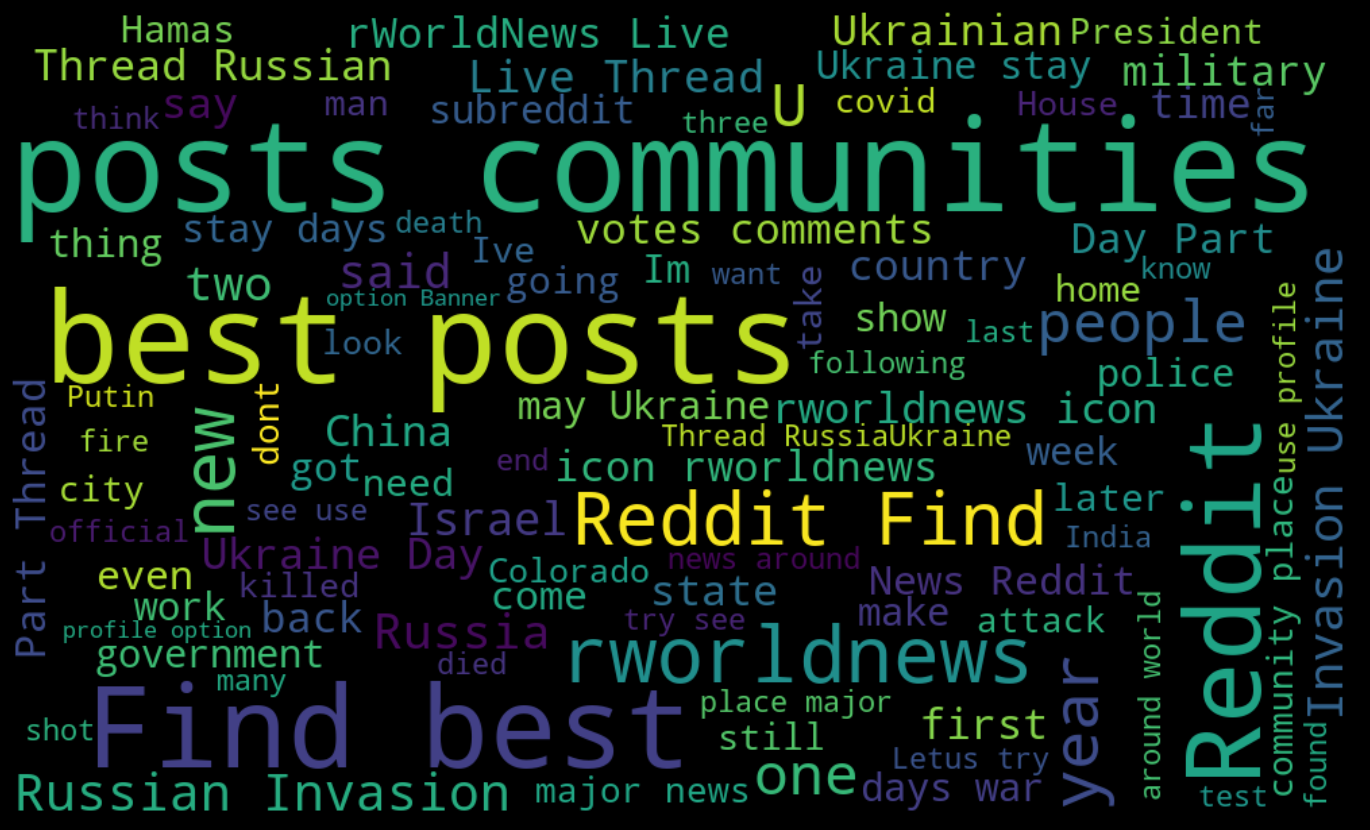

In [112]:
viz_data = data.copy(deep=True)

viz_data['worldnews'] = viz_data['worldnews'].apply(remove_stopwords) #removing stop words for visualizations only because it reduced the polarity for some text

text = ''.join( [post for post in viz_data['worldnews']] ) #To join all posts

# generate word cloud 
stopwords = STOPWORDS
wordcloud = WordCloud(width=1000, height = 600, 
                      max_words = 100,
                      stopwords = stopwords,
                      background_color='black').generate(text)

# Display the generated image:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')